## Problem 3
You have a European Call option with the following parameters
- Time to maturity: 3 months (0.25 years)
- Call Price: \$3.00
- Stock Price: \$31
- Strike Price: \$30
- Risk Free Rate: 10%
- No dividends are paid.
1. Calculate the implied volatility
2. Calculate the Delta, Vega, and Theta. Using this information, by approximately how
much would the price of the option change is the implied volatility increased by 1%.
Prove it.
3. Calculate the price of the put using Generalized Black Scholes Merton. Does Put-Call
Parity Hold?
4. Given a portfolio of
- a. 1 call
- b. 1 put
- c. 1 share of stock
Assuming the stock’s return is normally distributed with an annual volatility of 25%, the
expected annual return of the stock is 0%, there are 255 trading days in a year, and the implied volatility is constant. Calculate VaR and ES for a 20 trading day holding period, at alpha=5%
using:
- d. Delta Normal Approximation
- e. Monte Carlo Simulation
Hint: Don’t forget to include the option value decay in your calculations
5. Discuss the differences between the 2 methods. Hint: graph the portfolio value vs the
stock value and compare the assumptions between the 2 methods.

Implied Volatility: 0.3350803925099355
Delta: 0.6659296527298583 Vega: 5.6407054392888165 Theta: -5.544561508704643
Price Change due to 1% Vol Increase: 0.056407054392888165
Put Price: 1.2592973610256575
Put-Call Parity Difference: 1.7568169141668477e-10
VaR (Delta-Normal): -4.785010264573987 ES (Delta-Normal): -6.000595916296964
VaR (Monte Carlo): -5.182940189528495 ES (Monte Carlo): -6.625174763504876


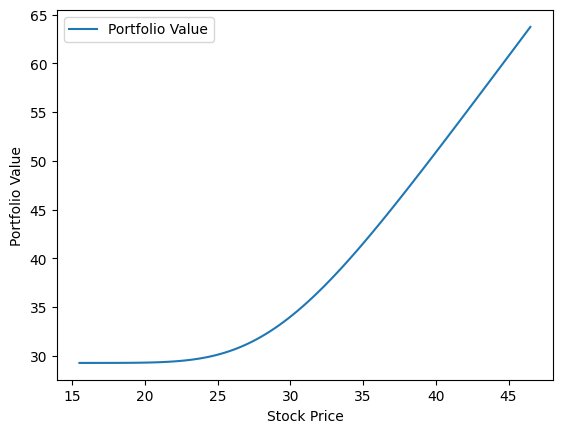

In [3]:
import numpy as np
import scipy.stats as si
import matplotlib.pyplot as plt

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * si.norm.cdf(d1) - K * np.exp(-r * T) * si.norm.cdf(d2)
    return call_price, d1, d2

def black_scholes_put(S, K, T, r, sigma):
    call_price, d1, d2 = black_scholes_call(S, K, T, r, sigma)
    put_price = K * np.exp(-r * T) * si.norm.cdf(-d2) - S * si.norm.cdf(-d1)
    return put_price

def implied_volatility(S, K, T, r, market_price, tol=1e-5, max_iter=100):
    sigma = 0.2  # Initial guess
    for i in range(max_iter):
        price, d1, d2 = black_scholes_call(S, K, T, r, sigma)
        vega = S * si.norm.pdf(d1) * np.sqrt(T)
        diff = market_price - price
        if abs(diff) < tol:
            return sigma
        sigma += diff / vega  # Newton-Raphson update
    return sigma

def option_greeks(S, K, T, r, sigma):
    _, d1, d2 = black_scholes_call(S, K, T, r, sigma)
    delta = si.norm.cdf(d1)
    vega = S * si.norm.pdf(d1) * np.sqrt(T)
    theta = (- (S * si.norm.pdf(d1) * sigma) / (2 * np.sqrt(T))
             - r * K * np.exp(-r * T) * si.norm.cdf(d2))
    return delta, vega, theta

def delta_normal_var_es(S, sigma, days=20, alpha=0.05):
    daily_vol = sigma / np.sqrt(255)
    portfolio_value = S
    z_score = si.norm.ppf(alpha)
    var = portfolio_value * daily_vol * np.sqrt(days) * z_score
    es = -portfolio_value * daily_vol * np.sqrt(days) * si.norm.pdf(z_score) / alpha
    return var, es

def monte_carlo_var_es(S, sigma, days=20, alpha=0.05, mc_sims=100000):
    daily_vol = sigma / np.sqrt(255)
    portfolio_value = S
    returns = np.random.normal(0, daily_vol, (mc_sims, days))
    portfolio_sim = S * np.exp(np.cumsum(returns, axis=1))
    losses = np.sort(portfolio_value - portfolio_sim[:, -1])
    var = losses[int(alpha * mc_sims)]
    es = np.mean(losses[:int(alpha * mc_sims)])
    return var, es

def plot_portfolio_value(S, sigma):
    stock_prices = np.linspace(S * 0.5, S * 1.5, 100)
    call_prices = [black_scholes_call(s, K, T, r, sigma)[0] for s in stock_prices]
    put_prices = [black_scholes_put(s, K, T, r, sigma) for s in stock_prices]
    portfolio_values = np.array(call_prices) + np.array(put_prices) + stock_prices
    plt.plot(stock_prices, portfolio_values, label='Portfolio Value')
    plt.xlabel('Stock Price')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

# Given data
S = 31  # Stock price
K = 30  # Strike price
T = 0.25  # Time to maturity in years
r = 0.10  # Risk-free rate
market_price = 3.00  # Call price

# Calculate implied volatility
implied_vol = implied_volatility(S, K, T, r, market_price)
print("Implied Volatility:", implied_vol)

# Calculate Greeks
delta, vega, theta = option_greeks(S, K, T, r, implied_vol)
print("Delta:", delta, "Vega:", vega, "Theta:", theta)

# Calculate change in price due to 1% increase in volatility
price_change = vega * 0.01
print("Price Change due to 1% Vol Increase:", price_change)

# Calculate put price and verify Put-Call Parity
put_price = black_scholes_put(S, K, T, r, implied_vol)
print("Put Price:", put_price)

put_call_parity = put_price + S - market_price - K * np.exp(-r * T)
print("Put-Call Parity Difference:", put_call_parity)

# Calculate VaR and ES using Delta-Normal Approximation
var_delta_normal, es_delta_normal = delta_normal_var_es(S, implied_vol)
print("VaR (Delta-Normal):", var_delta_normal, "ES (Delta-Normal):", es_delta_normal)

# Calculate VaR and ES using Monte Carlo Simulation
var_mc, es_mc = monte_carlo_var_es(S, implied_vol)
print("VaR (Monte Carlo):", var_mc, "ES (Monte Carlo):", es_mc)

# Plot portfolio value vs stock value
plot_portfolio_value(S, implied_vol)
